In [1]:
import string
from matplotlib import pyplot as plt
import numpy as np
from scipy.stats import poisson
from sklearn.utils import check_random_state
from sklearn import cluster
from scipy.stats import poisson
from scipy.optimize import minimize

# Read the data sequence

We are given a data sequence consisting on number of earthquakes for each year between the years 1900 and 2006.

In [2]:
state_seq = []
observation_seq = []
f = open('earthquakes.txt','r')
line = f.readline()
while line:
    line=line.rstrip().split('	')
    state_seq.append(int(line[0]))
    observation_seq.append(int(line[1]))
    line = f.readline()
    
state_seq = np.array(state_seq)
observation_seq = np.array(observation_seq)

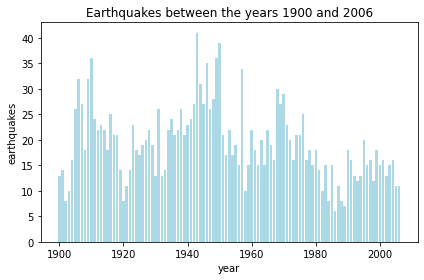

In [3]:
fig, ax = plt.subplots()

# the histogram of the data
plt.bar(state_seq, observation_seq, color='lightblue')

ax.set_xlabel('year')
ax.set_ylabel('earthquakes')
ax.set_title(r'Earthquakes between the years 1900 and 2006')

# Tweak spacing to prevent clipping of ylabel
fig.tight_layout()
plt.show()


# Direct maximization of the likelihood

The likelihood of a mixture model with m components is given, for both discrete and continuous cases by:

\begin{equation}

L(\theta_1,...,\theta_m,\delta_1,...,\delta_m|x_1,...,x_n) = \prod_{j=1}^n\sum_{i=1}^m\delta_ip_i(x_j,\theta_i)

\end{equation}
- Where $\theta_1,...,\theta_m$ are the paramenter vectors for the component distributions,
- $\delta_1,...,\delta_m$ are the mixing parameters, totalling 1,
- $x_1,...,x_n$ the $n$ observations.
Supose $m = 2$, and the two components are Poisson-distributed, which means $\lambda_1$ and $\lambda_2$. Let $\delta_1$ and $\delta_2$ be the mixing parameters (with $\delta_1+\delta_2 =1$). The mixture distribution $p$ is then given by:
\begin{equation}
p(x) = \delta_1\frac{\lambda^x_1e^{-\lambda_1}}{x!}+\delta_2\frac{\lambda^x_2e^{-\lambda_2}}{x!}
\end{equation}
Since $\delta_2 = 1 - \delta_1$, there are only three parameters to be estimated: $\lambda_1,\lambda_2$ and $\delta_1$. The likelihood is:
\begin{equation}
L(\lambda_1,\lambda_2,\delta_1|x_1,...,x_n) = \prod_{i=1}^n\delta_1\frac{\lambda^x_1e^{-\lambda_1}}{x_i!}+(1-\delta_1)\frac{\lambda^x_2e^{-\lambda_2}}{x_i!}
\end{equation}

The analytic maximization of $L$ with respect to $\lambda_1,\lambda_2$ and $\delta_1$ would be awkward, as $L$ is the product of $n$ factors, each of which is a sum. Therefore parameter estimation is more conveniently carried out by direct numerical maximization of the likelihood or its logarithm.
However, the parameters $\delta$ and $\lambda$ are constrained by $\sum^m_{i=1}\delta_i = 1$ and (for i=1,...,$m$)$\delta_i>0$ and $\lambda_i>0$. It is therefore necessary to reparametrize when using an unconstrained optimizer.
One possibility is to maximize the likelihood with respect to the 2m-1 unconstrained 'working parameters'.
\begin{equation}
\eta_i = log\lambda_i \; (i=1,...,m)
\end{equation}
and
\begin{equation}
\tau_i = log\left( \frac{\delta_i}{1-\sum^m_{j=2}\delta_j}\right) \; (i=2,...,m)
\end{equation}
and
\begin{equation}
\delta_1 = 1 - \sum^m_{j=2}\delta_i
\end{equation}

## Hidden Markov Models

### The likelihood

Consider a HMM in general with observation sequence $x_1,x_2,...,x_T$. The probability $L_T$ of observing that sequence is calculated under an m-state HMM which has initial distribution $\delta$ and transition probability matrix $\daleth$ for the markov chain and state-dependent probability (density) functions $p_i$.

The likelihood is then given by:
\begin{equation}
L_T = \delta P(x_1)\daleth P(x_2)...\daleth P(x_T)1'
\end{equation}
If $\delta$, the distribution of $C_1$, is the stationary distribution of the Markov chain, then in addition:
\begin{equation}
L_T = \delta\daleth P(x_1)\daleth P(x_2)...\daleth P(x_T)1'
\end{equation}

A crucial consequence of this expression of the likelihood is the forward algorithm.

#### The forward algorithm
The forward algorithm is a recursive computation of the likelihood, which is computationally much more efficient than the brute-force summation. This computational inexpensiveness is the key feature of HMMs.

We state the forward algorithm by the vector $\alpha_t$, for $t=1,2,...,T$ by:
\begin{equation}
\alpha_t = \delta P(x_1)\daleth P(x_2)...\daleth P(x_t) = \delta P(x_1)\prod_{s=2}^t\daleth P(x_s)
\end{equation}
So then the likelihood:
\begin{equation}
L_T = \alpha_T1'
\end{equation}
and:
\begin{equation}
\alpha_t = \alpha_{t-1}\daleth P(x_t) \;  for \; t\ge 2
\end{equation}

The elements of the vector $\alpha_t$ are referred as **forward probabilities**.
The number of operations is of order Tm^2. But there are several numerical problems to overcome:

- **Numerical (over/under)flow:** for discrete state-dependent distributions, the elements of $\alpha_t$, being made up of products of probabilities, become progressively smaller as $t$ increases. For the continous case, it reaches $\inf$. The solution is the same for over and underflow: scaling the vector $\alpha_t$ at eacht time $t$ so that its elemets sum up to 1.

\begin{equation}
\phi_t = \alpha_t/w_t, \; with \; w_t = \sum_i\alpha_t(i)
\end{equation}
Hence,
\begin{equation}
logL_T = \sum_{t=1}^Tlog(w_t/w_{t-1}) = \sum_{t=1}^Tlog(\phi_{t-1}\daleth P(x_t)1')
\end{equation}

- **Constraints:** we can have constrains that apply to the parameters of the state-dependent distributions, and to the parameters of the Markov chain. The relevant constrains for a Poisson HMM are:
    - the means $\lambda_i$ of the state-dependent distributions must be non-negative. This is easily solved by defining $\eta_i = \log\lambda_i$
   
    - The rows of the transition probability matrix $\daleth$ must sum up to one, with all parameters $\gamma_{ij}$ non-negative.


### The code

Here, the code for the maximum likelihood estimator of a Poisson distribution is implemented.

First, we start with the helper functions that add the previously mentioned constraints to our parameters.

In [4]:
def remove_diag(x):
    x_no_diag = np.ndarray.flatten(x)
    x_no_diag = np.delete(x_no_diag, range(0, len(x_no_diag), len(x) + 1), 0)
    x_no_diag = x_no_diag.reshape(len(x), len(x) - 1)
    return x_no_diag
def add_zero_diag(a):    
    b = np.zeros((a.shape[0], a.shape[1]+1), dtype=a.dtype)
    i = np.arange(b.shape[0])
    j = np.arange(b.shape[1])
    b[np.not_equal.outer(i, j)] = a.flat
    return b


def pn2pw(m,lmbda,gamma,delta=None,stationary=True):
    '''natural parameters to working parametes'''    
    # contraint for lambda
    tlambda = np.log(lmbda)
    if m == 1:
        return tlambda
    # contraint for transition probability matrix
    tgamma = np.log(gamma/np.diag(gamma))
    # discard diagonal elemets from the transformed vector
    tau = remove_diag(tgamma)
    print('tau',tau)
    if stationary:
        tdelta = None
    else:
        tdelta = np.log(delta)
        
    return tlambda,tau,tdelta
    
def pw2pn(m,tlambda,tau,tdelta,stationary=True):
    ''' working to natural parameters'''
    lmbda = np.exp(tlambda)
        
    # operations on tau to get off-diagonal elements of gamma
    element_exp = np.exp(tau)
    sumexp =1/(np.sum(element_exp,axis=1)+1).reshape((m,1))
    gamma = element_exp*sumexp
    # add diagonal elements to gamma
    gamma = add_zero_diag(gamma)
    gamma += np.diagflat(1-np.sum(gamma,axis=1))# fill diagonal making elements sum up to 1       
    
    if stationary:
        delta = np.linalg.solve(np.identity(m)-gamma+np.ones((m,m)),np.ones((1,m)).T)
    else:
        edelta = np.exp(tdelta)
        delta = edelta/np.sum(edelta,axis=0)
        
            
    return lmbda,gamma,delta
        

This function returns the -log likelihood of the poisson distribution. This is the value that we want to minimize afterwards in the optimization.

In [5]:
def poisson_mllk(vector,x,m,stationary):
    ''' vector has to be a 1D vector '''
    # read stored values
    # iterate as start+cellsize*index
    tlambda = vector[0:m].astype(float)
    tau = vector[m:m+m*m-m].astype(float) # vector[m:m+m].astype(float)

    tau = tau.reshape((m,m-1))
    if stationary: tdelta = None
    else: tdelta = vector[-m:]

    # if we only have 1 state
    if m==1: return (-np.sum(poisson.pmf(k=x,mu=np.exp(tlambda))))

    # get natural parameters
    lmbda,gamma,delta = pw2pn(m,tlambda,tau,tdelta,stationary=stationary)


    # for initial value
    alpha = delta.T * poisson.pmf(k=x[0],mu=lmbda)
    sum_alpha = np.sum(alpha)
    lscale = np.log(sum_alpha)
    alpha = alpha/sum_alpha  

    # for the rest of the values    
    for i in range (len(x)):
        alpha = alpha*np.matmul(gamma, poisson.pmf(k=x[i],mu=lmbda)) 
        sum_alpha = np.sum(alpha)
        lscale += np.log(sum_alpha)
        alpha = alpha/sum_alpha

        
    return -lscale

Maximum likelihood estimator of the poisson distribution. It minimizes the -log-likelihood using the gradient descent algorithm. The parameters with which this optimization is computed are the lambda, gamma and delta values.

In [6]:
def poisson_mle(x,observation_seq,m,lambda_ini,gamma_ini,delta_ini=None,stationary=True):
    ''' maximum likelihood estimation for a poisson distribution,
    given starting values for natural parameters'''
    # convert params to working parameters
    tlambda,tau,tdelta = pn2pw(m,lambda_ini,gamma_ini,delta_ini,stationary)
    # store in a vector of params to be optimized
    if tdelta is None: tdelta = 0
    partvec = np.hstack([tlambda.flatten(),tau.flatten(),tdelta])
    print('initial vector:', partvec)
    print('initial log likelihood:',poisson_mllk(partvec,x,m,stationary))
    # minimize log likelihood
    min_log = minimize(poisson_mllk,partvec,args = (x,m,stationary),method='CG', tol=1e-3)
    print('after minimization: \n',min_log)
    print(min_log.x)
    # convert params from minimization to natural parameters
    tlambda = min_log.x[0:m].astype(float)
    tau = min_log.x[m:m+m*m-m].astype(float)
    tau = tau.reshape((m,m-1))
    tdelta = min_log.x[-1]
    if tdelta==0: tdelta = None
    else: tdelta = min_log.x[-m]
    lmbda,gamma,delta = pw2pn(m,tlambda,tau,tdelta,stationary=stationary)
    print('final lambda values',lmbda)
    print('final gamma values', gamma)
    plot_poisson(state_seq,x,lmbda)
    

In [7]:
def plot_poisson(state_seq, observation_seq, lmbda):
    fig, ax = plt.subplots()

    # the histogram of the data
    plt.hist(observation_seq,20, density=True, facecolor='b', alpha=0.75)
    for mu in lmbda:
        plt.plot(observation_seq, poisson.pmf(observation_seq,mu), 'rs', lw=2 )

    ax.set_xlabel('# earthquakes')
    ax.set_ylabel('density')
    ax.set_title(r'Earthquakes between the years 1900 and 2006')

    # Tweak spacing to prevent clipping of ylabel
    fig.tight_layout()
    plt.show()

Fit a 2-state Hidden Markov Model with a stationary distribution

tau [[-2.19722458]
 [-2.19722458]]
initial vector: [ 2.30258509  2.99573227 -2.19722458 -2.19722458  0.        ]
initial log likelihood: 381.2906309315037
after minimization: 
      fun: 367.3028858908148
     jac: array([ 1.10626221e-04,  5.72204590e-05, -2.67028809e-05,  4.73022461e-04,
        0.00000000e+00])
 message: 'Optimization terminated successfully.'
    nfev: 284
     nit: 23
    njev: 47
  status: 0
 success: True
       x: array([ 2.72434347,  3.23711528, -2.19721791,  0.43981852,  0.        ])
[ 2.72434347  3.23711528 -2.19721791  0.43981852  0.        ]
final lambda values [15.24640098 25.46017026]
final gamma values [[0.8999994  0.1000006 ]
 [0.60821579 0.39178421]]


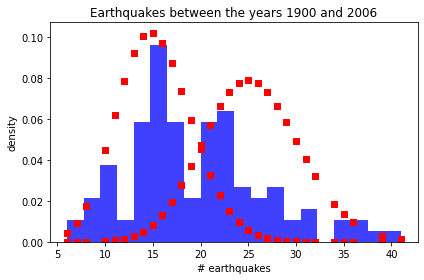

In [8]:
m = 2
lambda_ini = np.array([10,20])
gamma_ini = np.array([[0.9,0.1],[0.1,0.9]])
poisson_mle(observation_seq,state_seq,m,lambda_ini,gamma_ini,None,True)

Fit a 2-state Hidden Markov Model with a nonstationary distribution

tau [[-2.19722458]
 [-2.19722458]]
initial vector: [ 2.30258509  2.99573227 -2.19722458 -2.19722458 -0.69314718 -0.69314718]
initial log likelihood: 381.2906309315037
after minimization: 
      fun: 366.6097531131163
     jac: array([ 3.43322754e-05,  4.19616699e-05, -3.81469727e-06,  3.81469727e-06,
        1.14440918e-05, -1.14440918e-05])
 message: 'Optimization terminated successfully.'
    nfev: 800
     nit: 55
    njev: 114
  status: 0
 success: True
       x: array([ 2.72433331,  3.23710564, -2.19705127,  0.43972182, -6.30592084,
        4.91944539])
[ 2.72433331  3.23710564 -2.19705127  0.43972182 -6.30592084  4.91944539]
final lambda values [15.24624609 25.45992486]
final gamma values [[0.8999844  0.1000156 ]
 [0.60819274 0.39180726]]


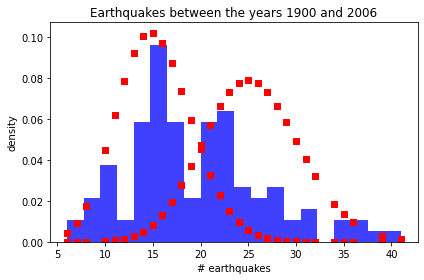

In [9]:
m = 2
lambda_ini = np.array([10,20])
gamma_ini = np.array([[0.9,0.1],[0.1,0.9]])
delta = np.array([0.5,0.5])
poisson_mle(observation_seq,state_seq,m,lambda_ini,gamma_ini,delta,False)

Fit a 3-state Hidden Markov Model with a nonstationary distribution

tau [[-3.6232292  -3.51083445]
 [-2.94968834 -2.62353126]
 [-2.25654115 -1.51807931]]
initial vector: [ 2.56494936  2.99573227  3.40119738 -3.6232292  -3.51083445 -2.94968834
 -2.62353126 -2.25654115 -1.51807931 -0.82098055 -0.90510354 -1.88453287]
initial log likelihood: 375.1404778941517
after minimization: 
      fun: 360.1564069697381
     jac: array([-2.78472900e-04, -4.76837158e-04,  1.64031982e-04,  0.00000000e+00,
        0.00000000e+00, -6.10351562e-05, -1.44958496e-04,  0.00000000e+00,
        0.00000000e+00,  3.73840332e-04, -7.59124756e-04,  3.85284424e-04])
 message: 'Optimization terminated successfully.'
    nfev: 4030
     nit: 165
    njev: 310
  status: 0
 success: True
       x: array([ 2.43897488,  2.92037285,  3.41211983, -3.62330642, -3.51078939,
       -1.35642304, -1.37454503, -2.25643303, -1.51804425, -3.84599393,
        4.04711484, -3.81173111])
[ 2.43897488  2.92037285  3.41211983 -3.62330642 -3.51078939 -1.35642304
 -1.37454503 -2.25643303 -1.51804425 -3.84

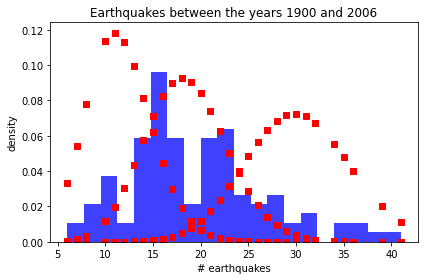

In [10]:
m = 3
lambda_ini = np.array([13,20,30])
gamma_ini = np.array([[0.955,0.024,0.021],[0.05,0.899,0.051],[0.1,0.197,0.703]])
delta = np.array([0.44,0.4045,0.1519])
poisson_mle(observation_seq,state_seq,m,lambda_ini,gamma_ini,delta,False)

# Standard errors via the Hessian

One can estimate the standard errors from the Hessian of the log-likelihood at the maximum, but this approach runs into difficulties when one of the parameters are on the boundary of their parameter space, which occurs quite often when HMMs are fitted. An alternative here is the parametric bootstrap, which on the other sime is time-consuming.

Although the point estimates are easy to compute, exact interval estimates are not available. Under certain regularity conditions, the MLEs of HMM parameters are consistent, asymptotically normal and efficient. Thus, if we can estimate the standard erros of MLEs, then, using the asymptotic normality, we can also compute the approximate confidence intervals. However, for mixture models, the sample size n has to be very large before the asymptotic theory of maximum likelihood applies.

Having this in mind, we can use the approximate Hessian of minus log-likelihood at the minimum to estimate the standard erros of the MLEs of an HMM. We can invert it and so estimate the asymptotic variance-covariance matrix of the estimators of the parameters. However, we need the Hessian with respect to the natural parameters, and not the working parameters.

# The EM algorithm 

## for a Mixture model of 3 Poisson distributions

In [11]:
from scipy.stats import poisson

Assuming that the earthquakes data is distributed according to a Poisson mixture model, here I will implement the EM algorithm to learn the probability parameters.

The data notation is as follows:

   - The full data $(X,Y)$ corresponding to periods with high and low amounts of earthquakes.
   - The observed data $ Y = y_i, i= 1,...,n$ corresponds to the number of earthquakes.
   - The missing data is "in what period we are for the amount of earthquakes", $X = (x_1,...,x_n) \in \{1,2,3\}^n$
   - The parameters $\theta = \{\lambda_1,\lambda_2,\lambda_3,\delta_1,\delta_2,\delta_3\}$
   
The EM algorithm converges towards a local maximum of the data log-likelihood function. It starts with an initializing value $\theta^0$, which is updated by an iterative procedure of two steps: the E step and the M step.

Considering a Poisson mixture of three components like we will do in this example, we have three disjoint events, with $\delta_k$ the probability of being in each of the three classes.
\begin{equation}
\delta_1 = P(x_i=1), \delta_2 = P(x_i=2), \delta_3 = P(x_i=3) = 1-\delta_1-\delta_2
\end{equation}
The probability of having our given data given that we are in a class k is given by:
\begin{equation}
y_i|x_i = 1∼Po(\lambda_1), y_i|x_i = 2∼Po(\lambda_2), y_i|x_i = 3∼Po(\lambda_3)
\end{equation}

In [12]:
X = state_seq
Y = observation_seq

### The E step

Since the complete log-likelihood is unknown, we use the posterior to evaluate the expectation of the complete data log-likelihood.

Computes the conditional probability that the hidden state $x_i=1$
\begin{equation}
P(X_i = 1 | Y_i = y_i) = 
\end{equation}

In [13]:
def E_step(delta,lmbda,data):
    # Handling errors
    if np.sum(delta)!=1:
        raise ValueError('Delta is not a probability distribution (the values dont sum up to 1)')
    # Conditional probability of delta given y
    delta_prob = 0
    for i in range (len(lmbda)):
        delta_prob += delta[i] * poisson.pmf(k=data,mu=lmbda[i])    
        
    # Conditional probability of each class given data
    # Probability of mixture 1 to m
    prob = []
    for i in range (len(lmbda)-1):
        prob.append(delta[i] * poisson.pmf(data,lmbda[i])/delta_prob)
      
    return prob

### The M step

Updates the probability parameters so that they maximize the expected value of the data log likelihood.

In [14]:
def M_step(prob ,delta, lmbda, data):    
    n_i = [] # number of times we expect to see each mixture, from xi = 1 to xi = m
    s_i = [] # sum of data points in the indicator components
    for i in range(len(lmbda)-1):
        n_i.append(np.sum(prob[i]))
        s_i.append(np.sum(data*prob[i]))
    n_i.append(len(data)-np.sum(n_i))
    s_i.append(np.sum(data)-np.sum(s_i))
    
    
    delta = np.asarray(n_i)/len(data)
    delta = np.append(delta,1-sum(delta))

        
    lmbda = np.divide(np.asarray(s_i),np.asarray(n_i))

    
    
    return delta, lmbda

In [15]:
def EM_algorithm(delta,lmbda,data,iterations):
    prob = 0.
    for i in range(iterations):
        prob = E_step(delta,lmbda,Y)
        delta,lmbda    = M_step(prob, delta,lmbda,Y)
        
    return delta,lmbda

In [16]:
Y = observation_seq
delta = np.array([0.5,0.4,0.1])
lmbda = np.array([10.,20.,30.])
EM_algorithm(delta,lmbda, Y, 100)

(array([0.27716677, 0.59308916, 0.12974408, 0.        ]),
 array([12.73203817, 19.78158473, 31.62645129]))

## For Hidden Markov Models

Now that we've studied the EM algorithm for mixture models, it's time to apply it to the Hidden Markov Model case.

The EM algorithm is the most common method for finding maximum-likelihood estimates of HMMs. To do so, we will need the forward and backward probabilities.

The forward probability was already formulated earlier in this notebook as:

\begin{equation}
\alpha_t = \delta P(x_1)\daleth P(x_2)...\daleth P(x_t) = \delta P(x_1)\prod_{s=2}^t\daleth P(x_s)
\end{equation}

with $\delta$ the initial distribution of the Markov chain.

The vector of backward probabilities is defined by:

\begin{equation}
\beta_t = \daleth P(x_1)\daleth P(x_2)...\daleth P(x_t)1' = \left(\prod_{s=t+1}^T\daleth P(x_s)\right)1'
\end{equation}

The forward probabilities are joint probabilities, and the backward probabilities are conditional.

A property of forward and backward probabilities that is applied in the EM algorithm to HMMs, follows that:

For t = 1,2,...,T and i = 1,2,...,m,
\begin{equation}
\alpha_t(i)\beta_t(i) = Pr(X^{(T)} = x^{(t)}, C_t = i),
\end{equation}
and consequently,
\begin{equation}
\alpha_t\beta'_t = Pr(X^{(T)} = x^{(t)}) = L_T,
\end{equation}
for each such $t$.
The next conclusion that follows from the matrix expression for the likelihood and the definitions of $\alpha_t$ and $\beta_t$:
\begin{align}
L_T &= \left( \delta P(x_1)\daleth P(x_2)...\daleth P(x_t)\right)\left( \daleth P(x_{t+1})...\daleth P(x_T)1' \right)
&= \alpha_t\beta'_t
\end{align}